In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import glob
import os
from radiomics import featureextractor
from math import isclose
import re
from scipy import ndimage, spatial, stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from nibabel.affines import apply_affine
%matplotlib widget
import seaborn as sns
import matplotlib.pyplot as plt
from traceback import format_exc

In [3]:
def fromspacetovox(inv_affine, where_space):

    mask_vox = (np.dot(inv_affine[:3, :3], where_space.T) + inv_affine[:3, 3:4]).T
    return mask_vox


def fromvoxtospace(affine, where_ones):

    mask_space = apply_affine(affine, where_ones)
    return mask_space


def load_nib_file(path):
    mask = nib.load(path)
    mask_data = mask.get_fdata()

    return mask, mask_data


def compute_dice_score(agg, gt):
    dice = 1 - spatial.distance.dice(agg.flatten(), gt.flatten())
    return dice


def extract_radiomics_features(list_train, path_data, errors, list_test=None, path_data_test=None):
    train_features = {}
    train_shape_features = {}
    if list_test is not None:
        list_to_parse = list_train + list_test
        test_features = {}
        test_shape_features = {}
    else:
        list_to_parse = list_train
    for case in list_to_parse:
        print(case)
        if case in list_train:
            path = path_data
        elif case in list_test:
            path = path_data_test

        image = glob.glob(path + case + '/T1_*_CR_2mm.nii.gz')
        mask = glob.glob(path + case + '/GT_RS_CR_2mm.nii.gz')

        try:
            features = featureextractor.RadiomicsFeatureExtractor()
            features.disableAllFeatures()
            features.enableFeatureClassByName('shape')
            results = features.execute(image[0], mask[0])
            features = {key[15:]: float(results[key]) for key in results.keys() if 'shape' in key}
            if case in list_train:
                train_features.update({case: results})
                train_shape_features.update({case: features})
            elif case in list_test:
                test_features.update({case: results})
                test_shape_features.update({case: features})
        except ValueError as e:
            errors.append(mask)
            result_to_print=re.search('ITK ERROR', format_exc())
            result_to_print_during=re.search('During handling', format_exc())
            print(format_exc()[result_to_print.span()[0]:result_to_print_during.span()[0]])
            
    if list_test is not None:
        return features.keys(), errors, train_features, train_shape_features, test_features, test_shape_features
    else:
        return errors, train_features, train_shape_features

In [4]:
# paths to train and test sets
path_data_baseline_ozgun = "/mnt/data/psteinmetz/neotex/data_MRI/2training_sets_forPCA/"
path_data_MP = "/mnt/data/psteinmetz/neotex/data_MRI/follow_up/Training/"
path_data_test = "/mnt/data/psteinmetz/neotex/data_MRI/follow_up/Testing/"
path_data_baseline_test = "/mnt/data/psteinmetz/neotex/data_MRI/baseline_data/Testing/"
path_data_sheet = "/mnt/data/psteinmetz/neotex/data_MRI/results_Training+Ozgun_test_BDD_25.ods"

In [5]:
# measured perf of algo
score = pd.read_excel(path_data_sheet, sheet_name="Sheet2", index_col='case')

# lists of cases
list_training_2sets = [x for x in os.listdir(path_data_baseline_ozgun) if '.' not in x]
list_training_MP = [x for x in os.listdir(path_data_MP) if '.' not in x]
list_testing = [x for x in os.listdir(path_data_test) if '.' not in x]
list_testing_baseline = [x for x in os.listdir(path_data_baseline_test) if '.' not in x]

errors = []

In [6]:
# extraction of radiomic features
errors_2sets, train_features_2sets, train_shape_features_2sets = extract_radiomics_features(list_training_2sets, path_data_baseline_ozgun, errors)
features, errors_MP, train_features_MP, train_shape_features_MP, test_features, test_shape_features = extract_radiomics_features(list_training_MP, path_data_MP, errors, list_testing, path_data_test)

case_56_Ozgun
case_16_Ozgun
case_1_Ozgun
case_51
case_51_Ozgun
case_116
case_60_Ozgun
case_48_Ozgun
case_7_Ozgun
case_50_Ozgun
case_124
case_22_Ozgun
case_59
case_52
case_36_Ozgun
case_42_Ozgun
case_53
case_25_Ozgun
case_96
case_18_Ozgun
case_130
case_17_Ozgun
case_98
case_13
case_73
case_59_Ozgun
case_61_Ozgun
case_47_Ozgun
case_30
case_5
case_122
case_11_Ozgun
case_93
case_53_Ozgun
case_0
case_37
case_115
case_44
case_100
case_139
case_49_Ozgun
case_62_Ozgun
case_35_Ozgun
case_21
case_128
case_136
case_33
case_5_Ozgun
case_20_Ozgun
case_97
case_95
case_23_Ozgun
case_6
case_135
case_58_Ozgun
case_83
case_125
case_40_Ozgun
case_29_Ozgun
case_28
case_92
case_123
case_111
case_25
case_84
case_41_Ozgun
case_114
case_86
case_99
case_90
case_32_Ozgun
case_79
case_107
case_57_Ozgun
case_4_Ozgun
case_24_Ozgun
case_45
case_133
case_8_Ozgun
case_38
case_141
case_55_Ozgun
case_89
case_104
case_108
case_14_Ozgun
case_12_Ozgun
case_120
case_34_Ozgun
case_119
case_40
case_9_Ozgun
case_134
case_71
c

In [7]:
# fit scaler + PCA model to baseline + ozgun train sets
scaler2 = StandardScaler().fit(pd.DataFrame.from_dict(train_shape_features_2sets).T)
X_train_scaled2 = scaler2.transform(pd.DataFrame.from_dict(train_shape_features_2sets).T)

pca2 = PCA(n_components=3)
pca2.fit(X_train_scaled2)
explained_variance_ratio2 = sum(pca2.explained_variance_ratio_)
X_train_PCA_projected2 = pca2.transform(X_train_scaled2)


# transform and project test set
X_test_scaled = scaler2.transform(pd.DataFrame.from_dict(test_shape_features).T)
X_test_PCA_projected = pca2.transform(X_test_scaled)

In [7]:
explained_variance_ratio2

0.8988242430386137

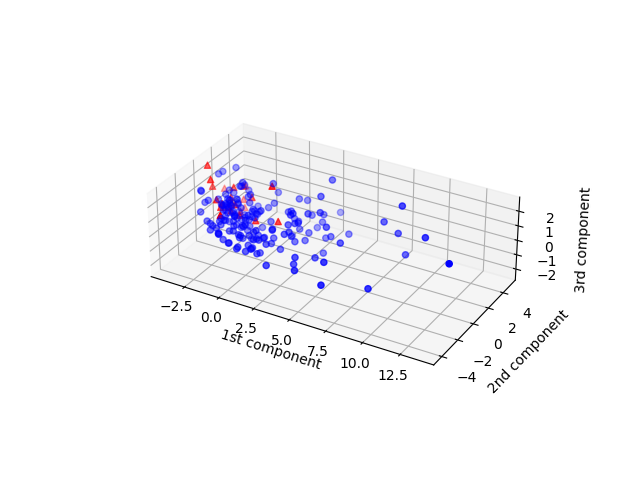

In [10]:
# plot in 3D reduced space train set (baseline + additional cases) and test set 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train_PCA_projected2[:, 0], X_train_PCA_projected2[:, 1], X_train_PCA_projected2[:, 2], c='b', marker='o')
ax.scatter(X_test_PCA_projected[:, 0], X_test_PCA_projected[:, 1], X_test_PCA_projected[:, 2], c='r', marker='^')
ax.set_xlim3d(min(min(X_train_PCA_projected2[:, 0]), min(X_test_PCA_projected[:, 0])),
              max(max(X_train_PCA_projected2[:, 0]),max(X_test_PCA_projected[:, 0])))
ax.set_ylim3d(min(min(X_train_PCA_projected2[:, 1]), min(X_test_PCA_projected[:, 1])),
              max(max(X_train_PCA_projected2[:, 1]), max(X_test_PCA_projected[:, 1])))
ax.set_zlim3d(min(min(X_train_PCA_projected2[:, 2]), min(X_test_PCA_projected[:, 2])),
              max(max(X_train_PCA_projected2[:, 2]), max(X_test_PCA_projected[:, 2])))

ax.set_box_aspect((np.ptp(X_train_PCA_projected2[:, 0]), np.ptp(X_train_PCA_projected2[:, 1]), np.ptp(X_train_PCA_projected2[:, 2]))) 
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')
plt.show()

In [8]:
# transform and project MP train sets in previous PCA 3D space
X_train_scaledMP = scaler2.transform(pd.DataFrame.from_dict(train_shape_features_MP).T)
X_train_PCA_projectedMP = pca2.transform(X_train_scaledMP)

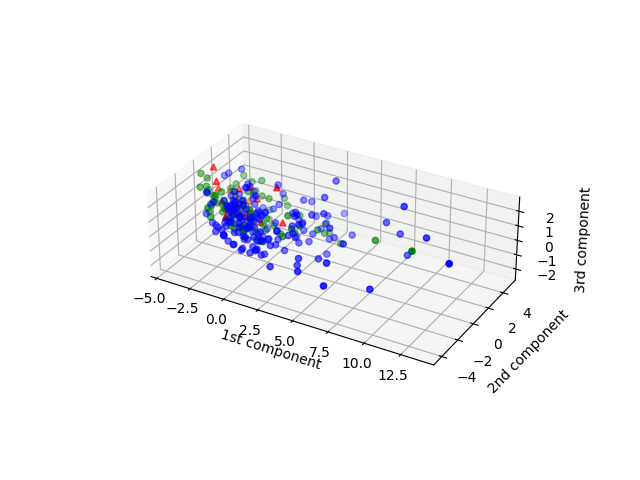

In [9]:
# plot in 3D reduced space train set (baseline + additional cases) + MP cases and test set 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train_PCA_projected2[:, 0], X_train_PCA_projected2[:, 1], X_train_PCA_projected2[:, 2], c='b', marker='o')
ax.scatter(X_train_PCA_projectedMP[:, 0], X_train_PCA_projectedMP[:, 1], X_train_PCA_projectedMP[:, 2], c='g', marker='o')
ax.scatter(X_test_PCA_projected[:, 0], X_test_PCA_projected[:, 1], X_test_PCA_projected[:, 2], c='r', marker='^')
ax.set_xlim3d(min(min(X_train_PCA_projected2[:, 0]), min(X_train_PCA_projectedMP[:, 0]), min(X_test_PCA_projected[:, 0])),
              max(max(X_train_PCA_projected2[:, 0]), max(X_train_PCA_projectedMP[:, 0]),max(X_test_PCA_projected[:, 0])))
ax.set_ylim3d(min(min(X_train_PCA_projected2[:, 1]), min(X_train_PCA_projectedMP[:, 1]), min(X_test_PCA_projected[:, 1])),
              max(max(X_train_PCA_projected2[:, 1]), max(X_train_PCA_projectedMP[:, 1]), max(X_test_PCA_projected[:, 1])))
ax.set_zlim3d(min(min(X_train_PCA_projected2[:, 2]), min(X_train_PCA_projectedMP[:, 2]), min(X_test_PCA_projected[:, 2])),
              max(max(X_train_PCA_projected2[:, 2]), max(X_train_PCA_projectedMP[:, 2]), max(X_test_PCA_projected[:, 2])))
ax.set_box_aspect((np.ptp(X_train_PCA_projected2[:, 0]), np.ptp(X_train_PCA_projected2[:, 1]), np.ptp(X_train_PCA_projected2[:, 2]))) 
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')
plt.show()

In [11]:
components_pca = pd.DataFrame(pca2.components_, columns=features)

In [12]:
components_pca

,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,SurfaceArea,SurfaceVolumeRatio,VoxelVolume
0,-0.066292,-0.111320,0.273310,0.309341,0.283567,0.318625,0.309919,0.301309,0.292675,0.318963,-0.171906,0.321218,-0.194975,0.293103
1,-0.471952,-0.521085,-0.289987,0.150586,-0.010381,0.075100,0.076902,0.128380,-0.168835,-0.111974,-0.424717,-0.035108,0.346413,-0.167800
2,0.587481,0.123684,-0.144574,-0.210817,-0.004102,0.014487,0.108215,0.007904,0.094676,0.135232,-0.422677,0.174841,0.562630,0.095879


In [13]:
pca2.explained_variance_ratio_

array([0.64140899, 0.20627152, 0.05114374])

In [14]:
components_pca.iloc[2].sort_values(axis=0)#.loc[abs(components_pca.iloc[0])>0.3]

Sphericity                -0.422677
MajorAxisLength           -0.210817
LeastAxisLength           -0.144574
Maximum2DDiameterColumn   -0.004102
Maximum3DDiameter          0.007904
Maximum2DDiameterRow       0.014487
MeshVolume                 0.094676
VoxelVolume                0.095879
Maximum2DDiameterSlice     0.108215
Flatness                   0.123684
MinorAxisLength            0.135232
SurfaceArea                0.174841
SurfaceVolumeRatio         0.562630
Elongation                 0.587481
Name: 2, dtype: float64

In [15]:
components_pca

,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,SurfaceArea,SurfaceVolumeRatio,VoxelVolume
0,-0.066292,-0.111320,0.273310,0.309341,0.283567,0.318625,0.309919,0.301309,0.292675,0.318963,-0.171906,0.321218,-0.194975,0.293103
1,-0.471952,-0.521085,-0.289987,0.150586,-0.010381,0.075100,0.076902,0.128380,-0.168835,-0.111974,-0.424717,-0.035108,0.346413,-0.167800
2,0.587481,0.123684,-0.144574,-0.210817,-0.004102,0.014487,0.108215,0.007904,0.094676,0.135232,-0.422677,0.174841,0.562630,0.095879


In [16]:
pd.DataFrame.from_dict(train_shape_features_2sets).T.corr()

,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,SurfaceArea,SurfaceVolumeRatio,VoxelVolume
Elongation,1.000000,0.800266,0.149797,-0.473578,-0.107076,-0.284836,-0.220143,-0.313803,0.027591,0.049443,0.491405,-0.101017,-0.178611,0.026625
Flatness,0.800266,1.000000,0.194837,-0.544454,-0.267636,-0.411339,-0.387348,-0.460750,-0.074517,-0.168350,0.733609,-0.255790,-0.265793,-0.076048
LeastAxisLength,0.149797,0.194837,1.000000,0.654510,0.682229,0.738428,0.691096,0.618768,0.825934,0.854383,-0.071917,0.784958,-0.819765,0.826134
MajorAxisLength,-0.473578,-0.544454,0.654510,1.000000,0.741275,0.925802,0.882574,0.868946,0.721076,0.825734,-0.599481,0.858648,-0.471745,0.722523
Maximum2DDiameterColumn,-0.107076,-0.267636,0.682229,0.741275,1.000000,0.755211,0.738840,0.900152,0.683230,0.802543,-0.403871,0.758081,-0.511912,0.684406
Maximum2DDiameterRow,-0.284836,-0.411339,0.738428,0.925802,0.755211,1.000000,0.898570,0.851897,0.780159,0.892623,-0.618716,0.920940,-0.492174,0.781805
Maximum2DDiameterSlice,-0.220143,-0.387348,0.691096,0.882574,0.738840,0.898570,1.000000,0.903387,0.722926,0.880520,-0.621264,0.884250,-0.460087,0.724862
Maximum3DDiameter,-0.313803,-0.460750,0.618768,0.868946,0.900152,0.851897,0.903387,1.000000,0.656591,0.806010,-0.612444,0.811259,-0.408192,0.658387
MeshVolume,0.027591,-0.074517,0.825934,0.721076,0.683230,0.780159,0.722926,0.656591,1.000000,0.880469,-0.212976,0.917299,-0.568266,0.999993
MinorAxisLength,0.049443,-0.168350,0.854383,0.825734,0.802543,0.892623,0.880520,0.806010,0.880469,1.000000,-0.401645,0.941228,-0.644362,0.881550


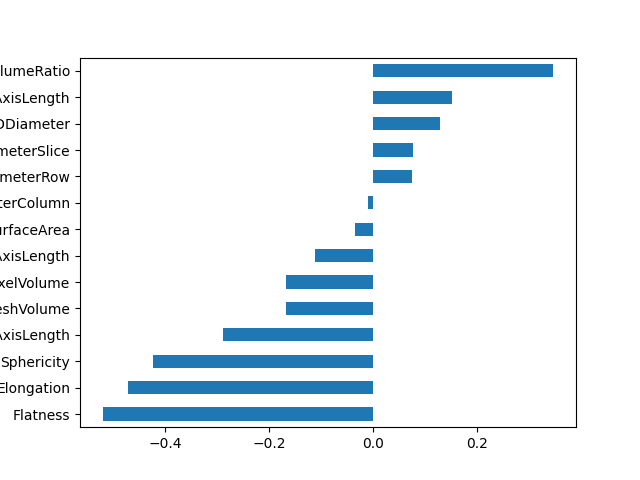

In [17]:
fig = plt.figure()
components_pca.iloc[1].sort_values(axis=0).plot(kind='barh')
plt.show()

In [18]:
components_pca.iloc[0].sort_values(axis=0)#.loc[abs(components_pca.iloc[0])>0.3]

SurfaceVolumeRatio        -0.194975
Sphericity                -0.171906
Flatness                  -0.111320
Elongation                -0.066292
LeastAxisLength            0.273310
Maximum2DDiameterColumn    0.283567
MeshVolume                 0.292675
VoxelVolume                0.293103
Maximum3DDiameter          0.301309
MajorAxisLength            0.309341
Maximum2DDiameterSlice     0.309919
Maximum2DDiameterRow       0.318625
MinorAxisLength            0.318963
SurfaceArea                0.321218
Name: 0, dtype: float64

In [19]:
components_pca.iloc[1].sort_values(axis=0)#.loc[abs(components_pca.iloc[1])>0.3]

Flatness                  -0.521085
Elongation                -0.471952
Sphericity                -0.424717
LeastAxisLength           -0.289987
MeshVolume                -0.168835
VoxelVolume               -0.167800
MinorAxisLength           -0.111974
SurfaceArea               -0.035108
Maximum2DDiameterColumn   -0.010381
Maximum2DDiameterRow       0.075100
Maximum2DDiameterSlice     0.076902
Maximum3DDiameter          0.128380
MajorAxisLength            0.150586
SurfaceVolumeRatio         0.346413
Name: 1, dtype: float64

In [20]:
components_pca.iloc[2].sort_values(axis=0)#.loc[abs(components_pca.iloc[2])>0.3]

Sphericity                -0.422677
MajorAxisLength           -0.210817
LeastAxisLength           -0.144574
Maximum2DDiameterColumn   -0.004102
Maximum3DDiameter          0.007904
Maximum2DDiameterRow       0.014487
MeshVolume                 0.094676
VoxelVolume                0.095879
Maximum2DDiameterSlice     0.108215
Flatness                   0.123684
MinorAxisLength            0.135232
SurfaceArea                0.174841
SurfaceVolumeRatio         0.562630
Elongation                 0.587481
Name: 2, dtype: float64

In [21]:
dist_scale_pca_baseline_ozgun = spatial.distance.cdist(X_test_PCA_projected, X_train_PCA_projected2, 'euclidean').T
distances_scale_pca_baseline_ozgun = pd.DataFrame(dist_scale_pca_baseline_ozgun, index=train_features_2sets.keys(), columns=test_features.keys())

In [22]:
distances_scale_pca_baseline_ozgun

,case_52_MP,case_47_MP,case_54_MP,case_68_MP,case_66_MP,case_50_MP,case_63_MP,case_58_MP,case_61_MP,case_51_MP,...,case_65_MP,case_83_MP,case_87_MP,case_56_MP,case_60_MP,case_102_MP,case_53_MP,case_48_MP,case_49_MP,case_67_MP
case_56_Ozgun,4.597259,6.010319,5.553227,5.295976,6.423802,5.629780,4.441161,3.830201,4.041142,5.383013,...,5.840337,6.625982,5.999209,5.180094,4.928665,7.049823,5.419489,5.819201,5.897593,6.887954
case_16_Ozgun,1.036395,2.828880,2.139474,1.649235,3.520141,2.050970,1.465827,1.370248,3.225257,1.627792,...,2.676290,3.320894,2.849638,1.453386,2.293919,3.540871,1.618017,2.137058,2.406886,3.289635
case_1_Ozgun,6.924517,7.093011,7.125609,8.119924,7.454631,7.671121,8.139725,5.873816,5.633683,7.577556,...,7.827005,9.273799,7.225941,7.739772,6.533084,8.619506,8.162471,8.532056,7.828438,9.134476
case_51,0.501777,2.285790,1.594681,1.106549,2.877706,1.367746,1.610124,1.346170,2.985858,0.987786,...,2.002902,2.745833,2.236104,0.794839,1.765703,2.859903,1.065408,1.567931,1.717772,2.643139
case_51_Ozgun,3.394091,5.045711,4.436058,3.998754,5.761209,4.497451,2.932145,2.947757,4.333783,4.095528,...,4.995850,5.565133,5.126570,3.907097,4.323192,5.999421,4.031783,4.509980,4.840027,5.718530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
case_137,1.988667,3.596538,3.049443,2.616027,3.985834,2.966443,2.132120,1.553444,2.389306,2.736900,...,3.220112,4.010942,3.515807,2.485244,2.493403,4.408423,2.741608,3.135430,3.239283,4.196655
case_36,9.536912,10.102941,10.019747,10.488202,10.223615,10.334053,10.159509,8.534408,7.681574,10.263325,...,10.308521,11.513459,10.101404,10.239026,9.136935,11.380645,10.616741,10.943778,10.483603,11.649285
case_33_Ozgun,2.190755,3.780530,3.076609,1.725602,4.347216,2.670454,0.908594,2.880448,4.403025,2.288665,...,3.223406,3.098177,3.743854,1.923172,3.416618,3.899478,1.678995,2.029924,2.965725,3.239167
case_57,1.243532,1.494350,1.243465,2.478869,2.225573,1.780767,3.243999,0.853851,2.372253,1.685379,...,2.243621,3.684453,1.596237,1.993002,1.110240,2.916118,2.434258,2.778881,1.989650,3.335722


In [23]:
knn_10_baseline_ozgun = distances_scale_pca_baseline_ozgun.transform(np.sort).reset_index(drop=True)
stats_baseline_ozgun = knn_10_baseline_ozgun.head(5).mean()
results_to_plot_baseline_ozgun = pd.concat((stats_baseline_ozgun, score['2trainsets']), axis=1).dropna()

In [24]:
knn_10_baseline_ozgun

,case_52_MP,case_47_MP,case_54_MP,case_68_MP,case_66_MP,case_50_MP,case_63_MP,case_58_MP,case_61_MP,case_51_MP,...,case_65_MP,case_83_MP,case_87_MP,case_56_MP,case_60_MP,case_102_MP,case_53_MP,case_48_MP,case_49_MP,case_67_MP
0,0.497537,0.854281,0.234740,0.158879,0.447260,0.493469,0.433192,0.631479,0.219743,0.413326,...,0.411488,0.851471,0.661652,0.245995,0.833300,1.286565,0.213137,0.368098,0.383911,0.898779
1,0.501777,0.880703,0.812543,0.363304,1.053765,0.635499,0.464162,0.656530,1.260328,0.515497,...,0.480554,0.948923,0.684702,0.254646,0.933371,1.470598,0.381042,0.459392,0.739322,1.122607
2,0.506688,0.928228,0.839929,0.476291,1.216852,0.645630,0.467379,0.660649,1.456992,0.669670,...,0.705718,1.083618,1.001386,0.384462,0.994960,1.531408,0.579180,0.556801,0.747385,1.239526
3,0.538890,1.059019,0.849750,0.527712,1.499752,0.682284,0.482998,0.669679,1.669947,0.683901,...,0.883886,1.195551,1.008350,0.437470,1.008674,1.546155,0.598352,0.756596,0.778352,1.339027
4,0.570920,1.162424,0.894223,0.542954,1.594911,0.731753,0.608902,0.733025,1.689156,0.750442,...,0.937320,1.353040,1.062991,0.447589,1.012781,1.561537,0.694904,0.770024,0.841635,1.407238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,10.999934,12.030103,11.537881,12.074722,12.250683,11.881709,11.416524,9.946584,9.534103,11.740936,...,12.003903,13.152132,12.062506,11.782241,11.016274,13.071514,12.158920,12.547147,12.070386,13.315379
172,11.507801,12.275765,12.128327,12.263034,12.515851,12.289821,11.687466,10.589487,10.000692,12.240360,...,12.153143,13.271933,12.193063,12.105205,11.113292,13.356151,12.439760,12.721683,12.426785,13.458053
173,11.610784,12.814535,12.450341,12.402396,13.290181,12.677807,11.757474,10.718572,10.713749,12.407444,...,12.903489,13.733248,12.886212,12.267396,11.866231,14.075403,12.506996,12.928553,12.949087,14.002101
174,13.233738,14.074792,13.890291,14.062874,14.219641,14.119952,13.424520,12.271170,11.477106,14.001798,...,14.101971,15.113646,14.059099,13.889434,13.006685,15.285892,14.213234,14.550428,14.298978,15.386238


In [25]:
stats_baseline_ozgun

case_52_MP     0.523163
case_47_MP     0.976931
case_54_MP     0.726237
case_68_MP     0.413828
case_66_MP     1.162508
case_50_MP     0.637727
case_63_MP     0.491327
case_58_MP     0.670272
case_61_MP     1.259233
case_51_MP     0.606567
case_69_MP     0.764826
case_64_MP     0.338287
case_84_MP     1.494761
case_57_MP     0.922789
case_65_MP     0.683793
case_83_MP     1.086521
case_87_MP     0.883816
case_56_MP     0.354033
case_60_MP     0.956617
case_102_MP    1.479253
case_53_MP     0.493323
case_48_MP     0.582182
case_49_MP     0.698121
case_67_MP     1.201435
dtype: float64

In [26]:
results_to_plot_baseline_ozgun

,0,2trainsets
case_52_MP,0.523163,0.003886
case_47_MP,0.976931,0.000000
case_54_MP,0.726237,0.000000
case_68_MP,0.413828,0.770957
case_66_MP,1.162508,0.000000
case_50_MP,0.637727,0.000000
case_63_MP,0.491327,0.824331
case_58_MP,0.670272,0.769737
case_61_MP,1.259233,0.713942
case_51_MP,0.606567,0.820170


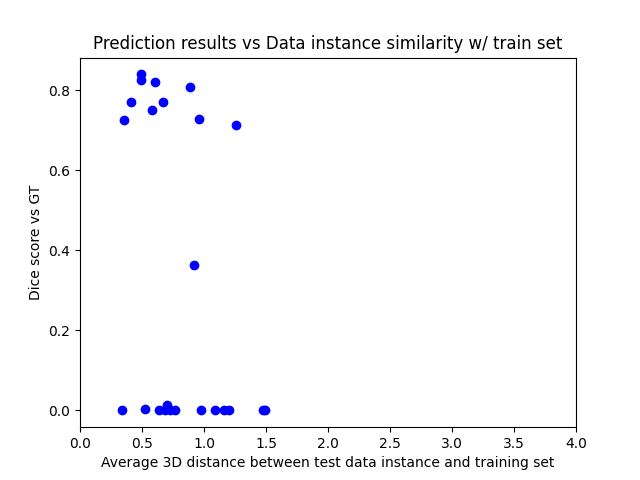

In [27]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(results_to_plot_baseline_ozgun[0], results_to_plot_baseline_ozgun['2trainsets'], c='b', marker='o')
ax.set_xlim(0, 4)
ax.set_xlabel('Average 3D distance between test data instance and training set')
ax.set_ylabel('Dice score vs GT')
ax.set_title('Prediction results vs Data instance similarity w/ train set')
plt.show()

In [28]:
dist_scale_pca_baseline_ozgun_MP = spatial.distance.cdist(X_test_PCA_projected, np.vstack((X_train_PCA_projected2, X_train_PCA_projectedMP)), 'euclidean').T
distances_scale_pca_baseline_ozgun_MP = pd.DataFrame(dist_scale_pca_baseline_ozgun_MP, index=list(train_features_2sets.keys())+list(train_features_MP.keys()), columns=test_features.keys())

In [29]:
distances_scale_pca_baseline_ozgun_MP

,case_52_MP,case_47_MP,case_54_MP,case_68_MP,case_66_MP,case_50_MP,case_63_MP,case_58_MP,case_61_MP,case_51_MP,...,case_65_MP,case_83_MP,case_87_MP,case_56_MP,case_60_MP,case_102_MP,case_53_MP,case_48_MP,case_49_MP,case_67_MP
case_56_Ozgun,4.597259,6.010319,5.553227,5.295976,6.423802,5.629780,4.441161,3.830201,4.041142,5.383013,...,5.840337,6.625982,5.999209,5.180094,4.928665,7.049823,5.419489,5.819201,5.897593,6.887954
case_16_Ozgun,1.036395,2.828880,2.139474,1.649235,3.520141,2.050970,1.465827,1.370248,3.225257,1.627792,...,2.676290,3.320894,2.849638,1.453386,2.293919,3.540871,1.618017,2.137058,2.406886,3.289635
case_1_Ozgun,6.924517,7.093011,7.125609,8.119924,7.454631,7.671121,8.139725,5.873816,5.633683,7.577556,...,7.827005,9.273799,7.225941,7.739772,6.533084,8.619506,8.162471,8.532056,7.828438,9.134476
case_51,0.501777,2.285790,1.594681,1.106549,2.877706,1.367746,1.610124,1.346170,2.985858,0.987786,...,2.002902,2.745833,2.236104,0.794839,1.765703,2.859903,1.065408,1.567931,1.717772,2.643139
case_51_Ozgun,3.394091,5.045711,4.436058,3.998754,5.761209,4.497451,2.932145,2.947757,4.333783,4.095528,...,4.995850,5.565133,5.126570,3.907097,4.323192,5.999421,4.031783,4.509980,4.840027,5.718530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
case_105_MP,1.747069,2.553047,2.138577,0.952774,2.275989,1.289778,2.166203,2.551237,2.748231,1.553479,...,0.907220,1.322707,2.142066,1.109560,1.695727,2.128339,1.199791,1.010267,1.264525,1.577256
case_16_MP,0.865126,2.409280,1.815108,2.040218,3.156097,1.997636,2.210584,0.549949,2.739380,1.645576,...,2.596395,3.613369,2.477179,1.677384,1.829779,3.465567,2.011087,2.497794,2.334429,3.473735
case_20_MP,1.665796,3.114029,2.602632,2.648173,3.682500,2.731223,2.464987,0.928753,2.412414,2.462867,...,3.124445,4.132849,3.125525,2.378943,2.208163,4.175529,2.702972,3.147176,3.026338,4.144120
case_39_MP,2.531814,3.869903,3.236824,1.441681,4.131107,2.557598,1.219769,3.423368,4.477156,2.366492,...,2.857910,2.228772,3.699690,1.878941,3.458315,3.482220,1.481198,1.511851,2.736174,2.560121


In [30]:
knn_10_baseline_ozgun_MP = distances_scale_pca_baseline_ozgun_MP.transform(np.sort).reset_index(drop=True)
stats_baseline_ozgun_MP = knn_10_baseline_ozgun_MP.head(10).mean()
results_to_plot_baseline_ozgun_MP = pd.concat((stats_baseline_ozgun_MP, score['3trainsets']), axis=1).dropna()

In [31]:
stats_baseline_ozgun_MP

case_52_MP     0.556171
case_47_MP     0.975284
case_54_MP     0.696857
case_68_MP     0.429828
case_66_MP     0.829514
case_50_MP     0.616554
case_63_MP     0.652910
case_58_MP     0.647898
case_61_MP     1.474986
case_51_MP     0.610587
case_69_MP     0.770881
case_64_MP     0.478740
case_84_MP     1.320787
case_57_MP     0.925075
case_65_MP     0.729923
case_83_MP     0.852469
case_87_MP     0.852727
case_56_MP     0.419081
case_60_MP     0.834208
case_102_MP    1.215509
case_53_MP     0.432753
case_48_MP     0.473258
case_49_MP     0.670648
case_67_MP     1.017519
dtype: float64

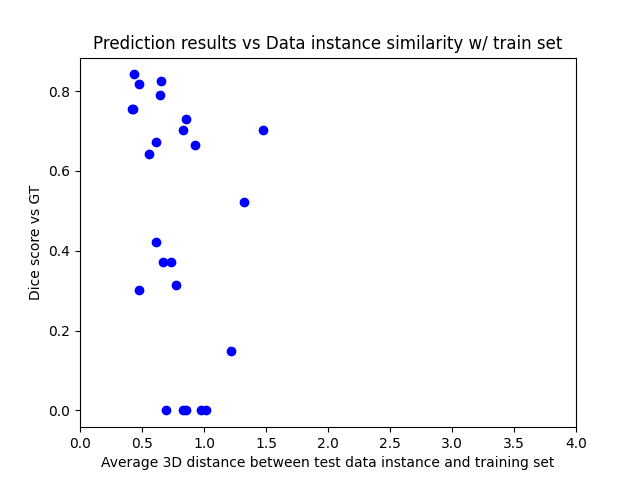

In [32]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(results_to_plot_baseline_ozgun_MP[0], results_to_plot_baseline_ozgun_MP['3trainsets'], c='b', marker='o')
ax.set_xlim(0, 4)
ax.set_xlabel('Average 3D distance between test data instance and training set')
ax.set_ylabel('Dice score vs GT')
ax.set_title('Prediction results vs Data instance similarity w/ train set')
plt.show()

In [33]:
features = pd.DataFrame.from_dict(train_shape_features_2sets).T

In [34]:
features

,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,SurfaceArea,SurfaceVolumeRatio,VoxelVolume
case_56_Ozgun,0.913418,0.688928,32.490993,47.161641,55.605755,49.396356,49.030603,56.462377,41047.333333,43.078280,0.700268,8217.563687,0.200197,41280.0
case_16_Ozgun,0.791901,0.742733,20.652025,27.805457,29.732137,30.528675,29.120440,32.124757,8608.333333,22.019160,0.823840,2465.590075,0.286419,8704.0
case_1_Ozgun,0.407968,0.340573,27.170692,79.779296,44.721360,72.277244,84.899941,89.576783,41198.333333,32.547366,0.551273,10464.141807,0.253994,41568.0
case_51,0.781507,0.698158,17.722059,25.384021,29.529646,27.856777,26.305893,29.597297,5842.666667,19.837787,0.805820,1946.794096,0.333203,5952.0
case_51_Ozgun,0.845995,0.833201,31.549181,37.865009,46.043458,37.947332,39.293765,46.690470,26791.000000,32.033621,0.869155,4981.723130,0.185948,26944.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
case_137,0.914632,0.639649,22.018408,34.422660,37.947332,39.446166,37.947332,40.249224,14506.666667,31.484052,0.734059,3918.606186,0.270125,14656.0
case_36,0.635348,0.381998,31.753664,83.125118,94.339811,94.021274,86.371292,95.540567,66920.333333,52.813371,0.423313,18830.456477,0.281386,67880.0
case_33_Ozgun,0.904744,0.886754,19.021360,21.450552,24.738634,24.738634,22.360680,25.059928,5696.000000,19.407252,0.925405,1666.730771,0.292614,5792.0
case_57,0.608154,0.550664,17.678598,32.104133,33.105891,32.802439,32.984845,37.202150,6475.333333,19.524250,0.722450,2325.508168,0.359133,6632.0


In [35]:
features.drop(['LeastAxisLength', 'MajorAxisLength', 'Maximum2DDiameterColumn', 'Maximum2DDiameterRow', 'Maximum2DDiameterSlice', 'Maximum3DDiameter', 'MeshVolume', 'MinorAxisLength', 'VoxelVolume'], axis=1).corr()

,Elongation,Flatness,Sphericity,SurfaceArea,SurfaceVolumeRatio
Elongation,1.000000,0.800266,0.491405,-0.101017,-0.178611
Flatness,0.800266,1.000000,0.733609,-0.255790,-0.265793
Sphericity,0.491405,0.733609,1.000000,-0.489433,-0.241853
SurfaceArea,-0.101017,-0.255790,-0.489433,1.000000,-0.507569
SurfaceVolumeRatio,-0.178611,-0.265793,-0.241853,-0.507569,1.000000


In [36]:
res_2sets = stats.normaltest(X_train_PCA_projected2, axis=None)

In [37]:
res_2sets

NormaltestResult(statistic=229.99893246332476, pvalue=1.1385874532721855e-50)

In [38]:
kernel2sets = stats.gaussian_kde(X_train_PCA_projected2.T)

In [39]:
kde2sets = kernel2sets(X_train_PCA_projected2.T)

In [40]:
kde2sets

array([0.0047929 , 0.01514372, 0.00153547, 0.0165653 , 0.00993474,
       0.01217782, 0.0109284 , 0.01036965, 0.01528229, 0.00963516,
       0.00076444, 0.01239488, 0.00528482, 0.00773087, 0.00780769,
       0.00224499, 0.01710901, 0.00224381, 0.00468985, 0.00799321,
       0.013145  , 0.00191577, 0.01592587, 0.00211825, 0.00918376,
       0.00971267, 0.00950995, 0.01215975, 0.0093043 , 0.01369183,
       0.0045644 , 0.0089544 , 0.00616324, 0.01515904, 0.00467994,
       0.01152616, 0.00079336, 0.00175819, 0.00518174, 0.01404891,
       0.01233241, 0.01281546, 0.00131191, 0.00393081, 0.0049649 ,
       0.00629774, 0.01312009, 0.01046256, 0.01629378, 0.0168634 ,
       0.00422599, 0.00717983, 0.01644448, 0.01655805, 0.00077217,
       0.01510208, 0.01585494, 0.00655785, 0.00077062, 0.01607069,
       0.00891853, 0.01298971, 0.00842635, 0.0048216 , 0.0119025 ,
       0.01460724, 0.01390265, 0.00101719, 0.01795531, 0.0134981 ,
       0.00181331, 0.00354546, 0.01210599, 0.00703391, 0.01522

In [41]:
for_size_scatterplot2 = (results_to_plot_baseline_ozgun['2trainsets']+0.1)*200

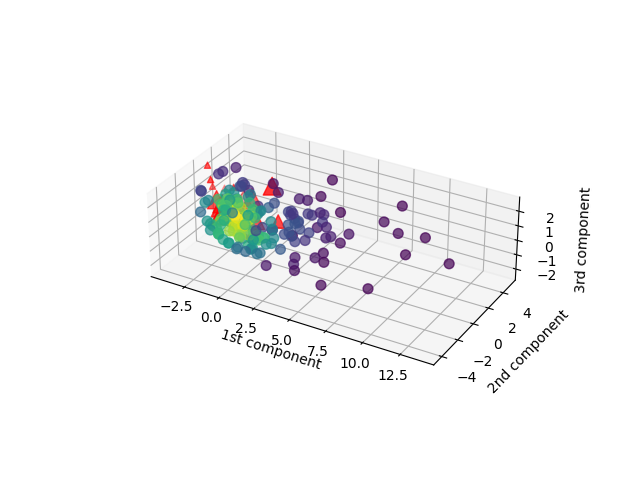

In [42]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_PCA_projected2[:, 0], X_train_PCA_projected2[:, 1], X_train_PCA_projected2[:, 2], c=kde2sets, marker='o', alpha=0.7, s=50)
ax.scatter(X_test_PCA_projected[:, 0], X_test_PCA_projected[:, 1], X_test_PCA_projected[:, 2], c='r',  marker='^', s=for_size_scatterplot2)
ax.set_xlim3d(min(min(X_train_PCA_projected2[:, 0]), min(X_test_PCA_projected[:, 0])),
              max(max(X_train_PCA_projected2[:, 0]), max(X_test_PCA_projected[:, 0])))
ax.set_ylim3d(min(min(X_train_PCA_projected2[:, 1]), min(X_test_PCA_projected[:, 1])),
              max(max(X_train_PCA_projected2[:, 1]), max(X_test_PCA_projected[:, 1])))
ax.set_zlim3d(min(min(X_train_PCA_projected2[:, 2]), min(X_test_PCA_projected[:, 2])),
              max(max(X_train_PCA_projected2[:, 2]), max(X_test_PCA_projected[:, 2])))
ax.set_box_aspect((np.ptp(X_train_PCA_projected2[:, 0]), np.ptp(X_train_PCA_projected2[:, 1]), np.ptp(X_train_PCA_projected2[:, 2])))
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')
plt.show()

In [43]:
results_2_sets=pd.DataFrame(kernel2sets.evaluate(X_test_PCA_projected.T), index=test_features)

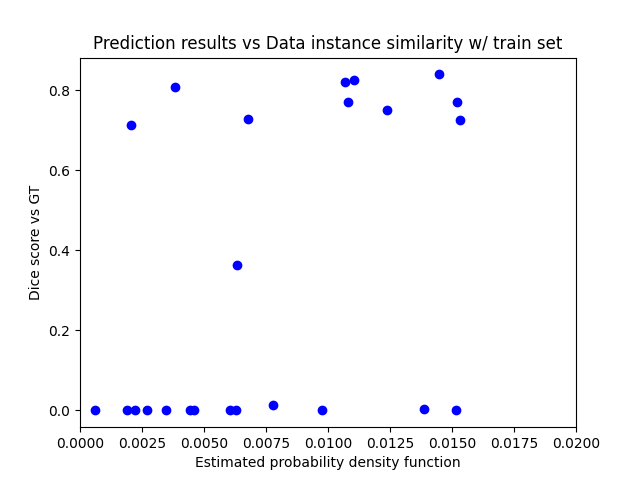

In [44]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(results_2_sets, results_to_plot_baseline_ozgun['2trainsets'], c='b', marker='o')
ax.set_xlim(0, 0.02)
ax.set_xlabel('Estimated probability density function')
ax.set_ylabel('Dice score vs GT')
ax.set_title('Prediction results vs Data instance similarity w/ train set')
plt.show()

In [45]:
train_3sets = np.vstack((X_train_PCA_projected2, X_train_PCA_projectedMP))

In [46]:
train_3sets.shape

(262, 3)

In [47]:
res_3sets = stats.normaltest(train_3sets, axis=None)

In [48]:
res_3sets

NormaltestResult(statistic=269.9973634675812, pvalue=2.348645438590654e-59)

In [49]:
kernel3sets = stats.gaussian_kde(train_3sets.T)

In [50]:
kde3sets = kernel3sets(train_3sets.T)

In [51]:
for_size_scatterplot = (results_to_plot_baseline_ozgun_MP['3trainsets']+0.1)*200

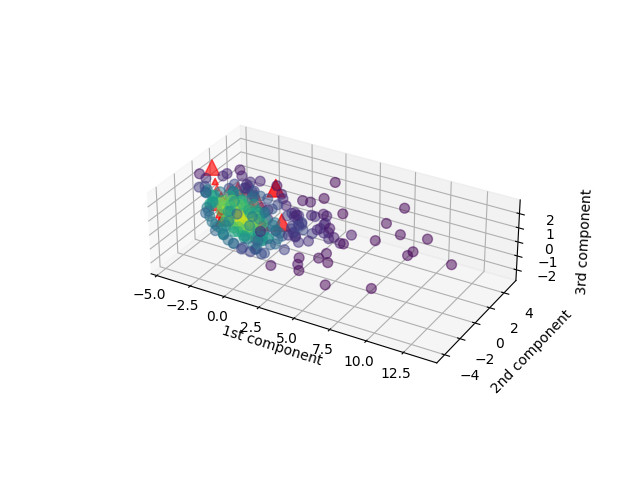

In [52]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.scatter(train_3sets[:, 0], train_3sets[:, 1], train_3sets[:, 2], c=kde3sets,  marker='o', alpha=0.5, s=50)
ax.scatter(X_test_PCA_projected[:, 0], X_test_PCA_projected[:, 1], X_test_PCA_projected[:, 2], c='r',  marker='^', s=for_size_scatterplot)
ax.set_xlim3d(min(min(train_3sets[:, 0]), min(X_test_PCA_projected[:, 0])),
              max(max(train_3sets[:, 0]), max(X_test_PCA_projected[:, 0])))
ax.set_ylim3d(min(min(train_3sets[:, 1]), min(X_test_PCA_projected[:, 1])),
              max(max(train_3sets[:, 1]), max(X_test_PCA_projected[:, 1])))
ax.set_zlim3d(min(min(train_3sets[:, 2]), min(X_test_PCA_projected[:, 2])),
              max(max(train_3sets[:, 2]), max(X_test_PCA_projected[:, 2])))
ax.set_box_aspect((np.ptp(train_3sets[:, 0]), np.ptp(train_3sets[:, 1]), np.ptp(train_3sets[:, 2]))) 
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('3rd component')
plt.show()

In [53]:
train_features_2sets.keys()

dict_keys(['case_56_Ozgun', 'case_16_Ozgun', 'case_1_Ozgun', 'case_51', 'case_51_Ozgun', 'case_116', 'case_60_Ozgun', 'case_48_Ozgun', 'case_7_Ozgun', 'case_50_Ozgun', 'case_124', 'case_22_Ozgun', 'case_59', 'case_52', 'case_36_Ozgun', 'case_42_Ozgun', 'case_53', 'case_25_Ozgun', 'case_96', 'case_18_Ozgun', 'case_130', 'case_17_Ozgun', 'case_98', 'case_13', 'case_73', 'case_59_Ozgun', 'case_61_Ozgun', 'case_47_Ozgun', 'case_30', 'case_5', 'case_122', 'case_11_Ozgun', 'case_93', 'case_53_Ozgun', 'case_0', 'case_37', 'case_115', 'case_44', 'case_100', 'case_139', 'case_49_Ozgun', 'case_62_Ozgun', 'case_35_Ozgun', 'case_21', 'case_128', 'case_136', 'case_33', 'case_5_Ozgun', 'case_20_Ozgun', 'case_97', 'case_95', 'case_23_Ozgun', 'case_6', 'case_135', 'case_58_Ozgun', 'case_83', 'case_125', 'case_40_Ozgun', 'case_29_Ozgun', 'case_28', 'case_92', 'case_123', 'case_111', 'case_25', 'case_84', 'case_41_Ozgun', 'case_114', 'case_86', 'case_99', 'case_90', 'case_32_Ozgun', 'case_79', 'case_107

In [54]:
pd.DataFrame(train_3sets, index=list(train_features_2sets.keys())+list(train_features_MP.keys())).sort_values(by=2)

,0,1,2
case_58_Ozgun,0.076451,3.396397,-2.662849
case_3_Ozgun,3.540771,1.419313,-1.928925
case_32_Ozgun,-1.074469,0.422848,-1.731246
case_124_MP,2.557635,3.375684,-1.671439
case_32_MP,3.884121,2.547473,-1.658919
...,...,...,...
case_13,-3.269512,2.180979,1.861609
case_75_MP,-5.034056,0.192964,2.026948
case_22,3.234700,3.051949,2.302371
case_120,14.302266,-2.667132,2.564243


In [55]:
results_3_sets=pd.DataFrame(kernel3sets.evaluate(X_test_PCA_projected.T), index=test_features)

In [56]:
results_3_sets.rename(columns={0:'result_kernel'}, inplace=True)
results_to_plot_baseline_ozgun_MP.rename(columns={'3trainsets':'Dice'}, inplace=True)

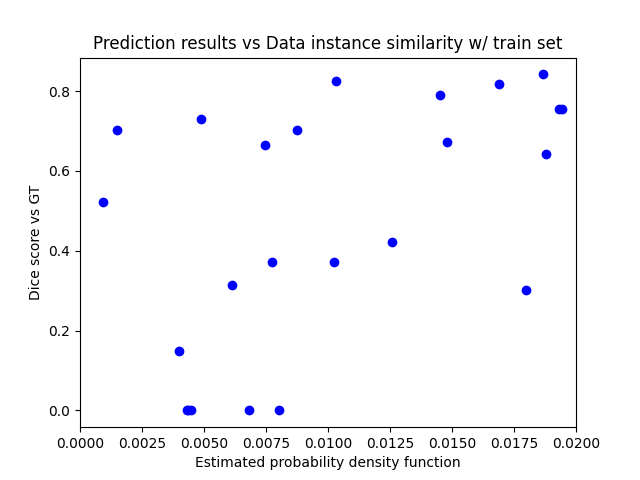

In [57]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(results_3_sets, results_to_plot_baseline_ozgun_MP['Dice'], c='b', marker='o')
ax.set_xlim(0, 0.02)
ax.set_xlabel('Estimated probability density function')
ax.set_ylabel('Dice score vs GT')
ax.set_title('Prediction results vs Data instance similarity w/ train set')
plt.show()

In [58]:
for_comprehension = pd.DataFrame((results_3_sets['result_kernel']*1000, results_to_plot_baseline_ozgun_MP['Dice'])).T

In [59]:
for_comprehension.sort_values(by='result_kernel')

,result_kernel,Dice
case_84_MP,0.933706,0.522727
case_61_MP,1.488253,0.702305
case_102_MP,3.993950,0.149123
case_47_MP,4.319055,0.000000
case_83_MP,4.366327,0.000000
case_66_MP,4.472568,0.000000
case_87_MP,4.865655,0.730490
case_69_MP,6.135423,0.313403
case_67_MP,6.804145,0.000000
case_57_MP,7.467214,0.665644


In [60]:
pd.DataFrame(X_test_PCA_projected, index=results_to_plot_baseline_ozgun_MP['Dice'].index)

,0,1,2
case_52_MP,-2.007406,0.554894,-0.380401
case_47_MP,-2.689749,2.197581,-0.818360
case_54_MP,-2.577641,1.494547,-0.758928
case_68_MP,-2.933755,0.002079,0.437517
case_66_MP,-2.932767,2.741154,0.406773
case_50_MP,-2.944518,1.097071,-0.013535
case_63_MP,-2.169748,-1.353895,0.490346
case_58_MP,-0.988684,0.800666,-0.603073
case_61_MP,-0.352769,1.774856,1.517447
case_51_MP,-2.784142,0.738491,-0.377713


In [61]:
features2=pd.DataFrame.from_dict(train_shape_features_2sets).T

In [62]:
featuresMP = pd.DataFrame.from_dict(train_shape_features_MP).T

In [63]:
featuresTest = pd.DataFrame.from_dict(test_shape_features).T

In [64]:
features2['set'] = 'Initial'

In [65]:
featuresMP['set'] = 'MP'

In [66]:
featuresTest['set'] = 'Test'

In [67]:
resume = pd.concat((features2, featuresMP, featuresTest))

In [68]:
resume

,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,SurfaceArea,SurfaceVolumeRatio,VoxelVolume,set
case_56_Ozgun,0.913418,0.688928,32.490993,47.161641,55.605755,49.396356,49.030603,56.462377,41047.333333,43.078280,0.700268,8217.563687,0.200197,41280.0,Initial
case_16_Ozgun,0.791901,0.742733,20.652025,27.805457,29.732137,30.528675,29.120440,32.124757,8608.333333,22.019160,0.823840,2465.590075,0.286419,8704.0,Initial
case_1_Ozgun,0.407968,0.340573,27.170692,79.779296,44.721360,72.277244,84.899941,89.576783,41198.333333,32.547366,0.551273,10464.141807,0.253994,41568.0,Initial
case_51,0.781507,0.698158,17.722059,25.384021,29.529646,27.856777,26.305893,29.597297,5842.666667,19.837787,0.805820,1946.794096,0.333203,5952.0,Initial
case_51_Ozgun,0.845995,0.833201,31.549181,37.865009,46.043458,37.947332,39.293765,46.690470,26791.000000,32.033621,0.869155,4981.723130,0.185948,26944.0,Initial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
case_102_MP,0.596835,0.572663,9.184385,16.038021,16.124515,17.204651,12.165525,17.320508,917.666667,9.572059,0.834258,547.402789,0.596516,976.0,Test
case_53_MP,0.802369,0.755694,14.526078,19.222169,19.697716,23.409400,22.803509,24.738634,2906.666667,15.423272,0.842246,1169.432995,0.402328,2984.0,Test
case_48_MP,0.838095,0.732922,12.855049,17.539456,18.867962,20.000000,18.439089,21.633308,2210.333333,14.699735,0.837020,980.362849,0.443536,2280.0,Test
case_49_MP,0.707664,0.586693,12.075447,20.582217,18.439089,22.803509,19.697716,24.083189,2261.666667,14.565300,0.785481,1060.801568,0.469035,2336.0,Test


In [69]:
train_shape_features_2sets['case_22']

{'Elongation': 0.6842596378018385,
 'Flatness': 0.5664615223743323,
 'LeastAxisLength': 31.080242260285107,
 'MajorAxisLength': 54.8673493832587,
 'Maximum2DDiameterColumn': 50.35871324805669,
 'Maximum2DDiameterRow': 79.12016177940993,
 'Maximum2DDiameterSlice': 70.11419257183242,
 'Maximum3DDiameter': 79.14543574963751,
 'MeshVolume': 22429.333333333332,
 'MinorAxisLength': 37.54351261613552,
 'Sphericity': 0.33206079147063877,
 'SurfaceArea': 11582.72563835757,
 'SurfaceVolumeRatio': 0.5164097151806074,
 'VoxelVolume': 23304.0}

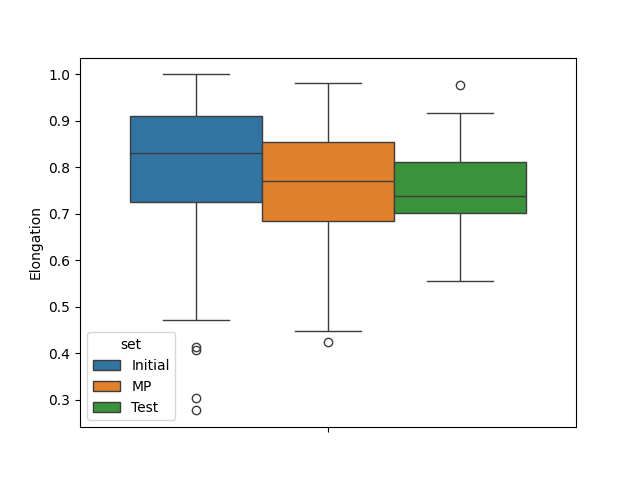

In [70]:
fig = plt.figure()
sns.boxplot(data=resume, y="Elongation", hue="set")
plt.show()

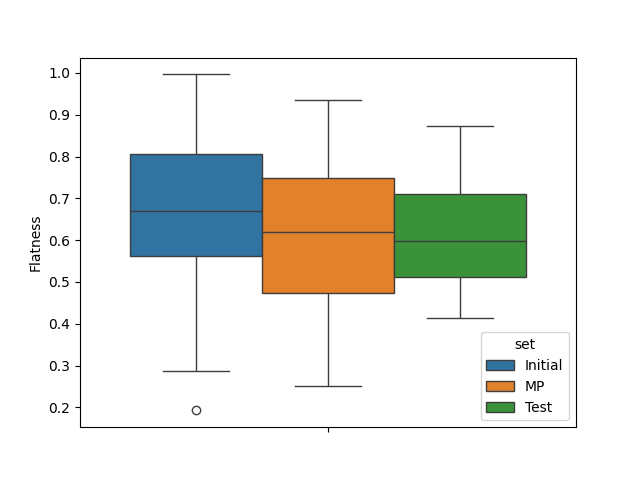

In [71]:
fig = plt.figure()
sns.boxplot(data=resume, y="Flatness", hue="set")
plt.show()

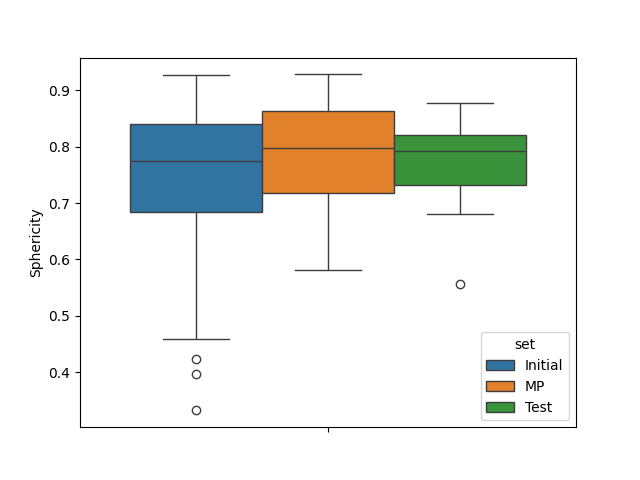

In [72]:
fig = plt.figure()
sns.boxplot(data=resume, y="Sphericity", hue="set")
plt.show()

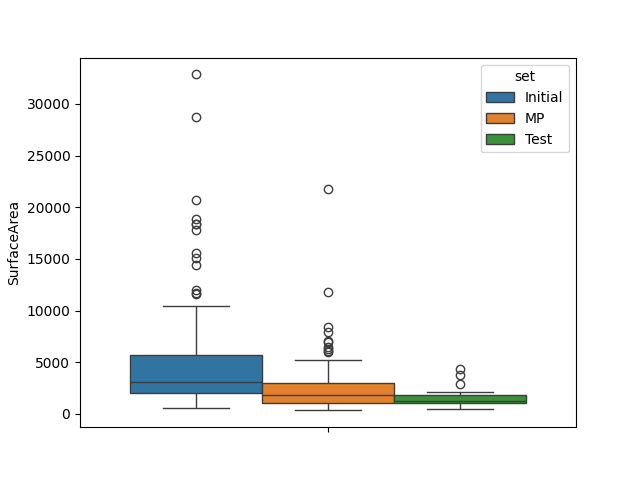

In [73]:
fig = plt.figure()
sns.boxplot(data=resume, y="SurfaceArea", hue="set")
plt.show()

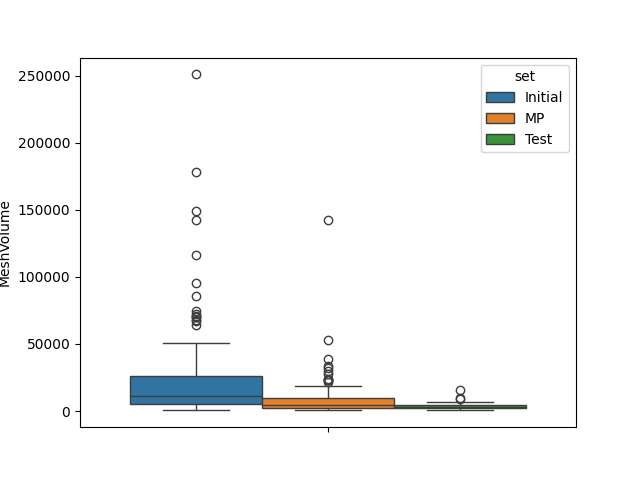

In [74]:
fig = plt.figure()
sns.boxplot(data=resume, y="MeshVolume", hue="set")
plt.show()

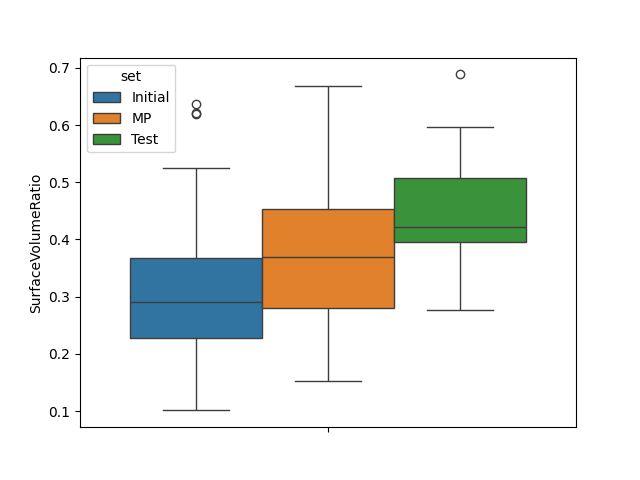

In [75]:
fig = plt.figure()
sns.boxplot(data=resume, y="SurfaceVolumeRatio", hue="set")
plt.show()

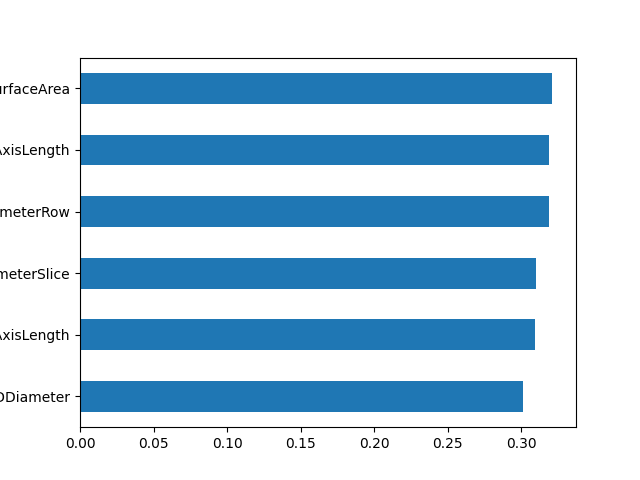

In [76]:
fig = plt.figure()
(components_pca.iloc[0].sort_values(axis=0).loc[abs(components_pca.iloc[0])>0.3]).plot(kind = 'barh')
plt.show()

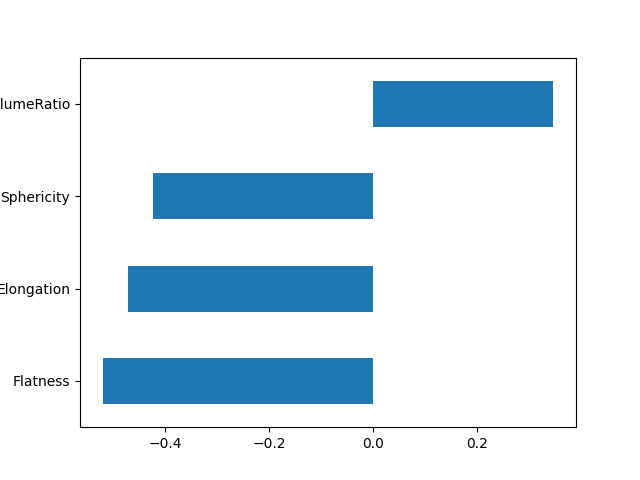

In [77]:
fig = plt.figure()
(components_pca.iloc[1].sort_values(axis=0).loc[abs(components_pca.iloc[1])>0.3]).plot(kind = 'barh')
plt.show()

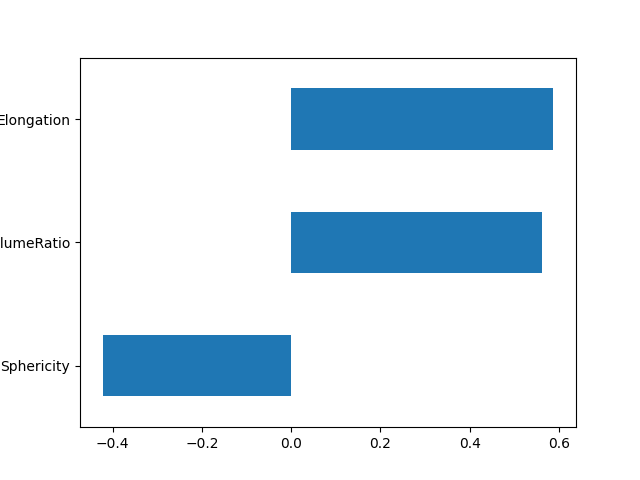

In [78]:
fig = plt.figure()
(components_pca.iloc[2].sort_values(axis=0).loc[abs(components_pca.iloc[2])>0.3]).plot(kind = 'barh')
plt.show()